In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm
from jax import jit
import sys
from scipy import interpolate


import jax.example_libraries.optimizers as jax_opt

import matplotlib.pyplot as plt


In [33]:
#initializes a set of NN parameters
def init_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            [jnp.array(np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in)),
            jnp.array(np.random.normal(size=(n_out,)))]
            )
        
    return params

#defines a NN for A where psi = e^-A given a set of N symmetrized inputs
@jit
def expA(x, params):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.celu(jnp.dot(jnp.array(x), jnp.array(layer[0])) + layer[1])
    result = jnp.dot(jnp.array(x), jnp.array(last[0])) + last[1]
    
    #return abs(result[0])
    return result[0]


#computes the symmetric coordinates that are fed into the NN
@jit
def get_inputs(positions):
    inputs = []
    num = 2.0
    n = 1
    while n <= NP:
        inputs.append(jnp.sum((jnp.array(positions)/num)**n))
        n += 1
    
    return inputs


#computes the NN for A; add a quadratic piece to multiply psi by a Gaussian
@jit
def bosonic_A(positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    inputs = get_inputs(positions)
    
    A = expA(inputs, Avariables) + 1.0*jnp.sum(jnp.array(positions)**2.)
    
    
    
    return A

#exponentiates A to get psi
@jit
def bosonic_psi(positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    A = bosonic_A(positions, Avariables)
    
    result = jnp.exp(-A)
    
    return result



#computes the potential without the delta function part
@jit
def potential_minus_delta(positions):
    
    harmonic_piece = 0.5*MASS*(OMEGA**2)*(jnp.sum(jnp.array(positions)**2.))
    
    interaction_piece = 0
    i = 0
    while i < NP:
        j = i + 1
        while j < NP:
        
            interaction_piece += SIGMA*jnp.abs(positions[i]-positions[j])
            j += 1
        i += 1
        
    return harmonic_piece + interaction_piece
    

#computes the delta function part of the potential namely psi^2(x, x)/psi^2(x, y) * g(y) 
#where g(y) is a Gaussian that integrates to 1.

@jit
def delta_part(positions, posprime, Avariables, width):

    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    num = bosonic_psi(posprime, Avariables)**2.
    denom = bosonic_psi(positions, Avariables)**2.

    delta = (1/(np.sqrt(np.pi)*width))*np.e**(-(positions[1]/width)**2)
    
    return (num/denom)*GCOUP*delta


#get monte carlo sequence

#useless ignore
@jit
def get_prob(xis, coord, positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    newpositions = positions.copy()
    positions[coord] += xis
    
    num = bosonic_psi(newpositions, Avariables)**2.
    denom = bosonic_psi(positions, Avariables)**2.
    
    prob = num/denom
    
    return [prob, list(newpositions), positions]

#this is the accept/reject statement; requires jax.lax.cond
#limit is a random number that I input as an argument 
#the random number itself is generated from the unjitted function get_sequence

@jit
def mcstep_E(xis, limit, positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    
    newpositions = jnp.array(positions) + xis
    
    num = bosonic_psi(newpositions, Avariables)**2.
    denom = bosonic_psi(positions, Avariables)**2.
    
    prob = num/denom
    
    def truefunc(p):
        return [list(newpositions), True]

    def falsefunc(p):
        return [list(positions), False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)


#actually gets the monte carlo sequence
def get_sequence(stepsize, Nsweeps, keep, Ntherm, positions_initial, Avariables, progress):
    sq = []
    counter = 0
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    
    randoms = np.random.uniform(-stepsize, stepsize, size = (Nsweeps, NP))
    limits = np.random.uniform(0, 1, size = Nsweeps)

    positions_prev = positions_initial
    
    if progress == True:
        for i in tqdm(range(0, Nsweeps), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, Avariables)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(Nsweeps):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, Avariables)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                sq.append(new)
                
            positions_prev = new

    return [sq, counter/Nsweeps]

#derivatives of the hamiltonian used to compute <E> and <dE/dt>

#computes the derivative of A with respect to the NN parameters Avariables

@jit
def derivA_theta(positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    deriv = jax.grad(bosonic_A, argnums = 1)
    
    dA_dtheta = deriv(jnp.array(positions), Avariables)
    
    return dA_dtheta


#computes the derivative of A with respect to position 
#returns first derivative and second derivative used for the Hamiltonian

@jit
def derivA_x(positions, Avariables):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    deriv = jax.grad(bosonic_A, argnums = 0)
    hess = jax.jacfwd(deriv, argnums = 0)
    
    dA = deriv(jnp.array(positions), Avariables)
    Hessian = hess(jnp.array(positions), Avariables)
    
    return [dA, jnp.diag(Hessian)]

#manipulations needed to multiply the format of the NN inputs by a scalar
@jit
def nn_mult(parameters, scalar):
    result = []
    for layer in parameters:
        newlay = []
        for mat in layer:
            newlay.append(scalar*mat)
        result.append(newlay)
    
    return result

#takes a mean of a list of NN inputs (need this function because the stored format of the NN is a list of np arrays)
def nn_mean(nnlist):
    
    answer = []
    for l in range(len(nnlist[0])):
        answer.append([nnlist[0][l][0], nnlist[0][l][1]])
    
    
    for p in range(1, len(nnlist)):
        for lay in range(len(answer)):
            answer[lay][0] = jnp.add(answer[lay][0], nnlist[p][lay][0])
            answer[lay][1] = jnp.add(answer[lay][1], nnlist[p][lay][1])
    
    return nn_mult(answer, 1/len(nnlist))
    

#get expectation values of <E> and <dE/dtheta>

#gexps computes energy of at a particular MC sample position.
#feed in the sample position as well as the position [x, x] (posprime) (jit does not do well with indexing arrays)
@jit
def gexps(pos, posprime, Avariables, width):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    factor = 0.5*NP*(NP-1)
    di, hi = derivA_x(pos, Avariables)

    energyminusdelta = (1/(2*MASS))*(jnp.sum(hi)-jnp.sum(jnp.array(di)**2)) + potential_minus_delta(pos)
    delta = factor*delta_part(pos, posprime, Avariables, width)

    energy = energyminusdelta + delta
            
    dAdt = derivA_theta(pos, Avariables)
    dAdtprime = derivA_theta(posprime, Avariables)
        
    
    return [energy, dAdt, nn_mult(dAdt, energyminusdelta), nn_mult(dAdtprime, delta)]
  
#this computes the energy at each MC sampled position and takes the average to get <E> and <dE/dtheta>
def get_expects(sequence, Avariables, width, progress):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    Numseqs = len(sequence)
    
    ens = []
    
    #the three terms involving derivatives w.r.t theta in eq. 18
    dAdts = []
    dAdts_times_Emds = []
    dAdts_times_ds = []
    
    if progress == True:
        for i in tqdm(range(0, Numseqs), position = 0, leave = True, desc = "Seq Calc"):
                        
            seqprime = sequence[i].copy()
            seqprime[1] = seqprime[0]
            
            energy, dAdt, dAdts_times_Emd, dAdts_times_d = gexps(sequence[i], seqprime, Avariables, width)
            
            ens.append(energy)
            dAdts.append(dAdt)
            dAdts_times_Emds.append(dAdts_times_Emd)
            dAdts_times_ds.append(dAdts_times_d)
            
    else:
        for i in range(Numseqs):
            
            seqprime = sequence[i].copy()
            seqprime[1] = seqprime[0]
            
            energy, dAdt, dAdts_times_Emd, dAdts_times_d = gexps(sequence[i], seqprime, Avariables, width)
            
            ens.append(energy)
            dAdts.append(dAdt)
            dAdts_times_Emds.append(dAdts_times_Emd)
            dAdts_times_ds.append(dAdts_times_d)

        
    return [np.mean(ens), nn_mean(dAdts), 
            nn_mean(dAdts_times_Emds), nn_mean(dAdts_times_ds), np.std(ens)/np.sqrt(len(ens))]

#returns the gradient w.r.t parameters, <E> and std(E)
def dEdt(stepsize, Nsweeps, keep, Ntherm, Avariables, progress):
    
    Avariables = jax.device_put(Avariables, device=jax.devices("cpu")[0])
    
    
    sequence, rate = get_sequence(stepsize, Nsweeps, keep, Ntherm, [0.]*NP, Avariables, progress)
    
    ys = []
    for thing in sequence:
        ys.append(thing[1])
    
    #width of the gaussian for g(y) chosen in a special way
    #width = np.max(abs(np.array(ys)))
    width = np.sqrt(np.max(abs(np.array(ys)))**2/-np.log(np.sqrt(np.pi)*(10**-10)))
    #width = 8.0

    
    expectations = get_expects(sequence, Avariables, width, progress)
    
    if progress == True:
        print("Accept rate: ", rate)
        print("Width: ", width)
        print("Energy: ", expectations[0])
        print("Error: ", expectations[4])
    
    first = nn_mult(expectations[1], 2.0*expectations[0])
    second = nn_mult(expectations[2], -2.0)
    third = nn_mult(expectations[3], -2.0)
    
    dEdtheta = nn_mult(nn_mean([first, second, third]), 3.0)
    
    
    return dEdtheta, expectations[0], expectations[4]

#Computes one training step using adam
def trainstep(stepsize, Nsweeps, keep, Ntherm, initial_params, step_i):
    
    grad, energy, err = dEdt(stepsize, Nsweeps, keep, Ntherm, initial_params, False)
    
    #print(energy, err)
    opt_state = opt_init(initial_params)
    new = opt_update(step_i, grad, opt_state)
    #print(new)
    
    return get_params(new), energy, err

#does the training over many training steps
#returns <E> at each step and the error, and the final set of parameters trained to
def train(Ntrains, stepsize, Nsweeps, keep, Ntherm, initial_params):
    old_params = initial_params.copy()
    
    energies = []
    errs = []
    ns = np.arange(Ntrains)

    for n in tqdm(range(0, Ntrains), position = 0, leave = True, desc = "Training"):
        new_params, energy, err = trainstep(stepsize, Nsweeps, keep, Ntherm, old_params, n)
        energies.append(energy)
        errs.append(err)
        old_params = new_params.copy()

        
    return [ns, energies, errs, old_params]

In [34]:
OMEGA = 1.0
MASS = 1.0


NP = 2

In [5]:
lss = [NP, 50, 100, 100, 50, 1]

In [35]:
Avars_init = init_params(lss)

In [36]:
#how many parameters in the NN
lis = lss
i = 0
total = 0
while i < len(lis)-1:
    total += lis[i]*lis[i+1] + lis[i+1]
    i += 1
print(total)

20451


In [37]:
GCOUP = 0.0
SIGMA = 1.0

In [38]:
info = dEdt(1.0, 200000, 100, 1000, Avars_init, True)

Seq Calc: 100%|██████████| 1990/1990 [00:01<00:00, 1756.05it/s]


Accept rate:  0.470275
Width:  0.4805706938416454
Energy:  1.7719606
Error:  0.014497416930776085


In [39]:
opt_init, opt_update, get_params = jax_opt.adam(5*10**-4)

In [40]:
resultsa = train(10, 1.0, 200000, 100, 1000, Avars_init)

Training: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


In [22]:
print(np.min(resultsa[1]))

1.7019395


In [24]:
opt_init, opt_update, get_params = jax_opt.adam(10**-4)

In [29]:
resultsb = train(10, 1.0, 200000, 100, 1000, resultsa[3])

Training: 100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


In [32]:
total_hists = resultsa[1] + resultsb[1]
total_uncerts = resultsa[2] + resultsb[2]
print(np.min(total_hists))

1.6875352


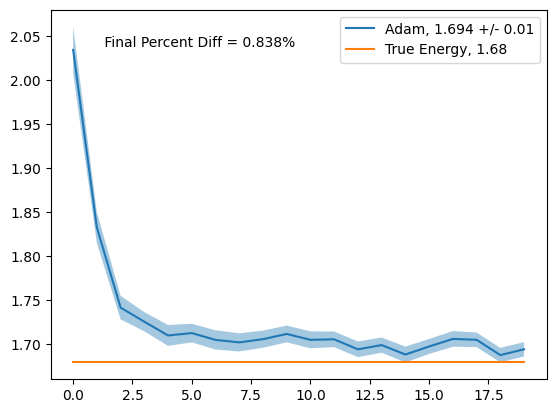

In [42]:

true_energy = 1.68
plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam, " + str(round(total_hists[-1],3)) + " +/- " + str(round(total_uncerts[-1], 2)))
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (total_hists[-1] - true_energy)/true_energy*100
plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.show()